## Expectation-Maximisation Algorithm

* enables **parameter estimation** in probabilistic models with **incomplete data**
    * The parameters θ maximize the likelihood.
    * The likelihood, p(y|θ), is the probability of the visible variables given the parameters.
* was originally motivated by missing data imputation - 1977, Arthur Dempster, Nan Laird, and Donald Rubin
* is a probabilistic clustering algorithm: determining the probabilities that instances belong to particular clusters
* is simplier than Gradient Methods - no need to choose a step size.

#### Application of this EM?

Unsupervised clustering algorithms:
- Hidden Markov Model
- K-means (difficult if clusters overlap)
- Gausian Mixture Model (clusters modelled as Gaussians)

### The EM optimisation has two steps:

1. Guess some cluster centers
* Repeat until converged:
    * E-step: assign points to the nearest cluster center
        * treats *parameters as fixed*
        * E for **Expectation**
        * updating our expectation of which cluster each point belongs to
            * i.e. **probabilistic assignments** (update for unobserved/hidden/latent variables)
    * M-step: set the cluster centers to the mean
        * treats *assignment probabilities as fixed*
        * M for **Maximisation**
        * maximising a objective function (e.g. mean) that defines the location of the cluster centers 
            * i.e. **update estimates of parameters**

## Example: estimate the parameters of TWO Gaussian distributions

### Imagine we have some data

e.g. unlabelled data from a population made of two Gaussian distributions:

1. $x^{(a)} \sim N(\mu_a, \sigma^2_a)$
* $x^{(b)} \sim N(\mu_b, \sigma^2_b)$

We observe the values for $x = [x^{(a)}, x^{(b)}]$ (unlabelled)

We want to understand each distribution, and thus want to know their mean and variance.

Text(0,0.5,'Frequency')

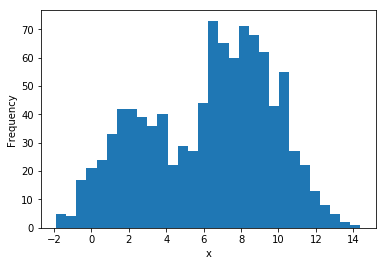

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# np.random.seed(77)

mean_popn = np.array([2, 8])
stdev_popn = np.array([1.5, 2])
proportion_true = 0.70 # probability of data being generated from the second distibution
n = 1000

z = np.random.binomial(1, proportion_true, n) # z = either 0 or 1, not directly observed
x = np.random.normal(mean_popn[z], stdev_popn[z]) # observed

plt.hist(x, bins=30, label='Samples')

plt.xlabel('x')
plt.ylabel('Frequency')

#### To help visualise this, we can add the population pdfs, via the "density=1"

What does "density=1" do?
* counts normalized to form a probability density, i.e., the area (or integral) under the histogram will sum to 1
    * dividing the count by the number of observations times the bin width

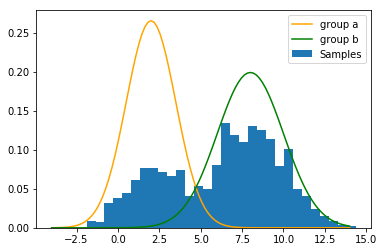

In [2]:
plt.hist(x, bins=30, density=1, label='Samples')

from scipy.stats import norm
x_linspace = np.linspace(-4, 14, 100)
plt.plot(x_linspace, norm.pdf(x_linspace, mean_popn[0], stdev_popn[0]), label = 'group a', c = 'orange')
plt.plot(x_linspace, norm.pdf(x_linspace, mean_popn[1], stdev_popn[1]), label = 'group b', c = 'g')

plt.legend(loc=0)

## E step: probabilistic assignments (i.e. estimate probabilities, given parameters)

In [3]:
from scipy.stats import norm

def e_step(x, mean, stdev, proportion):
    a = proportion * norm.pdf(x, mean[0], stdev[0])
                     # probability of x being from first distribution, "orange"
    b = (1. - proportion) * norm.pdf(x, mean[1], stdev[1])
                            # probability of x being from second distribution, "green"
    return b / (a + b)
           # (scaled) probability of x belongs to the second distribution, "green"
           # "responsibility allocated to cluster"
           # "assignment probabilities"
        
                # a + b
                # = total probability of observing x in our data
                # = sum of probabilities of observing x in each cluster weighted by that cluster’s probability

#### probability that $x_i$ belonging to second distribution

In [4]:
e_step(4, mean_popn, stdev_popn, proportion_true)
# unlikely to belong to the second distribution
# (we know that 2 is the mean of the first distribution)

0.09568717716301355

* why so small? 

    * let us calculate the e_step() at "x=4" manually

0.09568717716301353

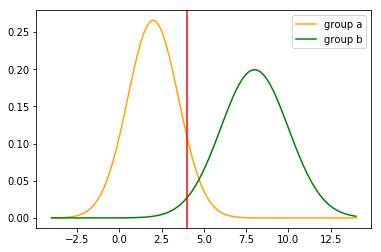

In [5]:
plt.plot(x_linspace, norm.pdf(x_linspace, mean_popn[0], stdev_popn[0]), label = 'group a', c = 'orange')
plt.plot(x_linspace, norm.pdf(x_linspace, mean_popn[1], stdev_popn[1]), label = 'group b', c = 'g')
plt.axvline(x=4, c = 'r')

plt.legend(loc=0)

# calculate the e_step at "x=4" manually
a = 0.7 * norm.pdf(4, 2, 1.5)
b = 0.3 * norm.pdf(4, 8, 2)
b / (a + b)

In [6]:
e_step(1, mean_popn, stdev_popn, proportion_true)
# "1" is unlikely to belong to the second distribution
# (we know that the second distribution has a mean of 8 and stdev of 2)

0.0008773229243378644

In [7]:
e_step(6, mean_popn, stdev_popn, proportion_true)

# "6" is likely to belong to the second distribution

0.8722026093400294

#### probability that $x_i$ belonging to second distribution: visualisation

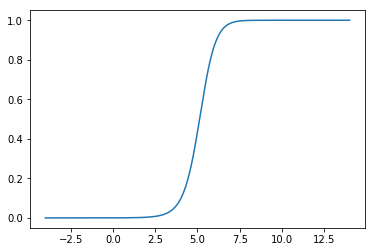

In [8]:
x_range = np.linspace(-4,+14,1000)
plt.plot(x_range, e_step(x_range, mean_popn, stdev_popn, proportion_true))

## M step: estimates of parameters, given assigned probabilities

Question to answer here: how likely is each data point to have come from each normal distribution with E step parameters (mean and standard deviation)

In [9]:
def m_step(x, w):
    proportion = np.mean(w) 
    
    # weighted mean of data
    mean = [np.sum((1-w) * x)/np.sum(1-w), 
            np.sum(w * x)/np.sum(w)] 
    
    # weighted cov of data
    stdev = [np.sqrt(np.sum((1-w) * (x - mean[0])**2)/np.sum(1-w)), 
             np.sqrt(np.sum(w * (x - mean[1])**2)/np.sum(w))]
    
    return mean, stdev, proportion

## EM Algorithm

In [10]:
# Initialize values
mean = np.random.normal(size=2)
stdev = np.random.uniform(0, 10, 2)
proportion = np.random.random()

print('\ninitial random values')
print('proportion: {0:.4f}\ngroup a:    N({1:.4f}, {2:.4f})\ngroup b:    N({3:.4f}, {4:.4f})'.format(
                    proportion, mean[0], stdev[0], mean[1], stdev[1]))

# Stopping criterion
crit = 0.01 # 1e-2

# Convergence flag
converged = False

# Loop until converged
while not converged:
    
    # E-step
    w = e_step(x, mean, stdev, proportion) # "reshuffle" data into clusters
    # M-step
    mean_new, stdev_new, proportion_new = m_step(x, w) # update estimates
    
    # Check convergence
    converged = ((np.abs(proportion_new - proportion) < crit) 
                 & np.all(np.abs((np.array(mean_new) - np.array(mean)) < crit))
                 & np.all(np.abs((np.array(stdev_new) - np.array(stdev)) < crit)))
    mean, stdev, proportion = mean_new, stdev_new, proportion_new
                    
    print('\nproportion:  {0:.4f}\ngroup 0:     N({1:.4f}, {2:.4f})\ngroup 1:     N({3:.4f}, {4:.4f})'.format(
                        proportion_new, mean_new[0], stdev_new[0], mean_new[1], stdev_new[1]))


initial random values
proportion: 0.2047
group a:    N(0.7407, 2.9287)
group b:    N(0.4616, 8.1612)

proportion:  0.8343
group 0:     N(3.1633, 2.5020)
group 1:     N(6.8459, 3.2295)

proportion:  0.3759
group 0:     N(4.6935, 3.0164)
group 1:     N(8.7959, 2.2991)

proportion:  0.5325
group 0:     N(3.7773, 2.9076)
group 1:     N(8.3936, 2.1036)

proportion:  0.5031
group 0:     N(3.8551, 2.8738)
group 1:     N(8.5869, 1.9497)

proportion:  0.5048
group 0:     N(3.7671, 2.7977)
group 1:     N(8.6573, 1.8670)

proportion:  0.5059
group 0:     N(3.7046, 2.7290)
group 1:     N(8.7077, 1.8207)

proportion:  0.5074
group 0:     N(3.6579, 2.6765)
group 1:     N(8.7383, 1.7942)

proportion:  0.5088
group 0:     N(3.6249, 2.6401)
group 1:     N(8.7561, 1.7786)

proportion:  0.5099
group 0:     N(3.6025, 2.6160)
group 1:     N(8.7662, 1.7694)

proportion:  0.5108
group 0:     N(3.5879, 2.6006)
group 1:     N(8.7719, 1.7639)


### Compare estimates from sample data eith the original population

In [11]:
print('proportion:  {0:.4f}\ngroup a:     N({1:.4f}, {2:.4f})\ngroup b:     N({3:.4f}, {4:.4f})'.format(
                        proportion_true, mean_popn[0], stdev_popn[0], mean_popn[1], stdev_popn[1]))

proportion:  0.7000
group a:     N(2.0000, 1.5000)
group b:     N(8.0000, 2.0000)


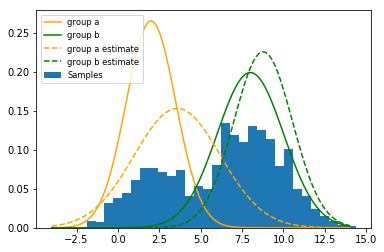

In [12]:
plt.hist(x, bins=30, density=1, label='Samples')

from scipy.stats import norm
x_linspace = np.linspace(-4, 14, 100)
plt.plot(x_linspace, norm.pdf(x_linspace, mean_popn[0], stdev_popn[0]), label = 'group a', c = 'orange')
plt.plot(x_linspace, norm.pdf(x_linspace, mean_popn[1], stdev_popn[1]), label = 'group b', c = 'g')
plt.plot(x_linspace, norm.pdf(x_linspace, mean[0], stdev[0]), label = 'group a estimate', c = 'orange', linestyle='dashed')
plt.plot(x_linspace, norm.pdf(x_linspace, mean[1], stdev[1]), label = 'group b estimate', c = 'g', linestyle='dashed')

plt.legend(fontsize='small')

## issues?

* convergence is not guaranteed: for a global optimum 
* local optima: depends on initialisation (similar to gradient descent)

## what if we want to know a single cluster/distribution for each data point $x_i$?

* choose the most probable cluster/distribution

    * the cluster or distribution with the largest "assigned probability"